In [3]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [4]:
# DATA

# import

station_id=5001
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
data['acquisition_timestamp'] = pd.to_datetime(data['acquisition_timestamp'], utc=True)


In [5]:

# pivoting
new_data = data.pivot_table(index='acquisition_timestamp', columns='parameter_type', values='value').reset_index()
new_data.set_index('acquisition_timestamp', inplace=True)


# relative humidity
humidity = new_data[['RELATIVE_HUMIDITY']]
print(humidity)

# count the NaN values
nan_count_humidity = humidity['RELATIVE_HUMIDITY'].isna().sum()
print(nan_count_humidity)
# there are no NaN values

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=humidity.index.min(), end=humidity.index.max(), freq='5T')
missing_timestamps = complete_range.difference(humidity.index)
print(len(missing_timestamps))
print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
len(df_complete_range)
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# fill the missing measurements with the measurment at that time on the previous day (!problem: if the measurment of the previous day at that time is also missing. solution: take the next day)

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
humidity_incomplete = df_complete_range.merge(humidity, left_index=True, right_index=True, how='left')
print(humidity_incomplete)
humidity_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
humidity_all = humidity_incomplete.bfill()
print(humidity_all)
humidity_all.isna().sum() # okay

str(humidity_all.index.dtype) # okay

parameter_type             RELATIVE_HUMIDITY
acquisition_timestamp                       
2020-10-13 10:20:00+00:00               63.9
2020-10-13 10:25:00+00:00               62.5
2020-10-13 10:30:00+00:00               61.9
2020-10-13 10:35:00+00:00               62.2
2020-10-13 10:40:00+00:00               62.2
...                                      ...
2023-05-31 21:35:00+00:00               89.2
2023-05-31 21:40:00+00:00               89.2
2023-05-31 21:45:00+00:00               89.3
2023-05-31 21:50:00+00:00               89.3
2023-05-31 21:55:00+00:00               89.4

[271508 rows x 1 columns]
0
5112
DatetimeIndex(['2020-10-13 10:20:00+00:00', '2020-10-13 10:25:00+00:00',
               '2020-10-13 10:30:00+00:00', '2020-10-13 10:35:00+00:00',
               '2020-10-13 10:40:00+00:00', '2020-10-13 10:45:00+00:00',
               '2020-10-13 10:50:00+00:00', '2020-10-13 10:55:00+00:00',
               '2020-10-13 11:00:00+00:00', '2020-10-13 11:05:00+00:00',
               .

'datetime64[ns, UTC]'

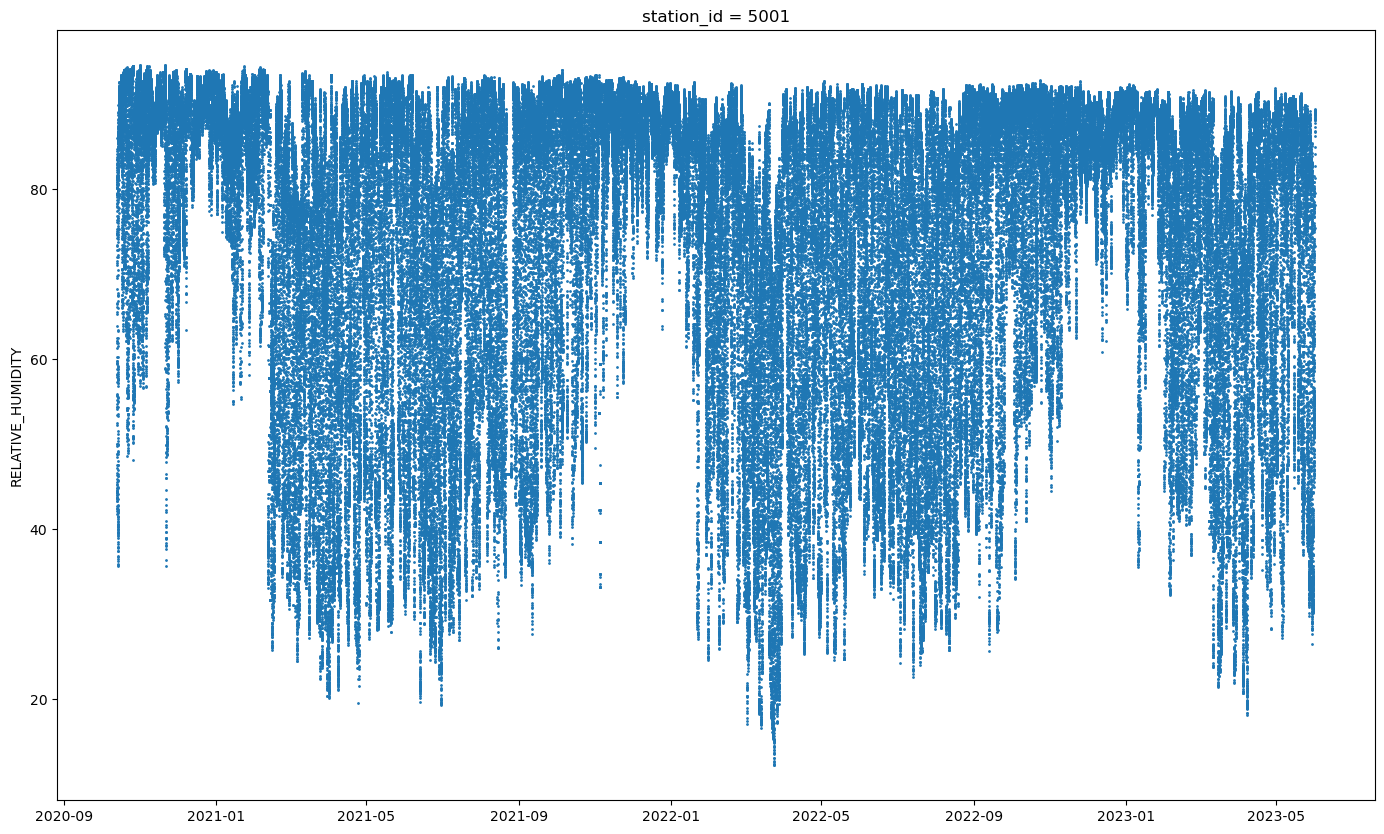

In [6]:
# plot 'RELATIVE_HUMIDITY'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(humidity_all.index, humidity_all['RELATIVE_HUMIDITY'],s=1)
ax.set_ylabel('RELATIVE_HUMIDITY')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

                           RELATIVE_HUMIDITY
2020-10-13 10:00:00+00:00          61.675000
2020-10-13 11:00:00+00:00          56.825000
2020-10-13 12:00:00+00:00          48.391667
2020-10-13 13:00:00+00:00          43.625000
2020-10-13 14:00:00+00:00          44.483333
...                                      ...
2023-05-31 17:00:00+00:00          56.250000
2023-05-31 18:00:00+00:00          67.583333
2023-05-31 19:00:00+00:00          78.716667
2023-05-31 20:00:00+00:00          87.975000
2023-05-31 21:00:00+00:00          89.108333

[23052 rows x 1 columns]


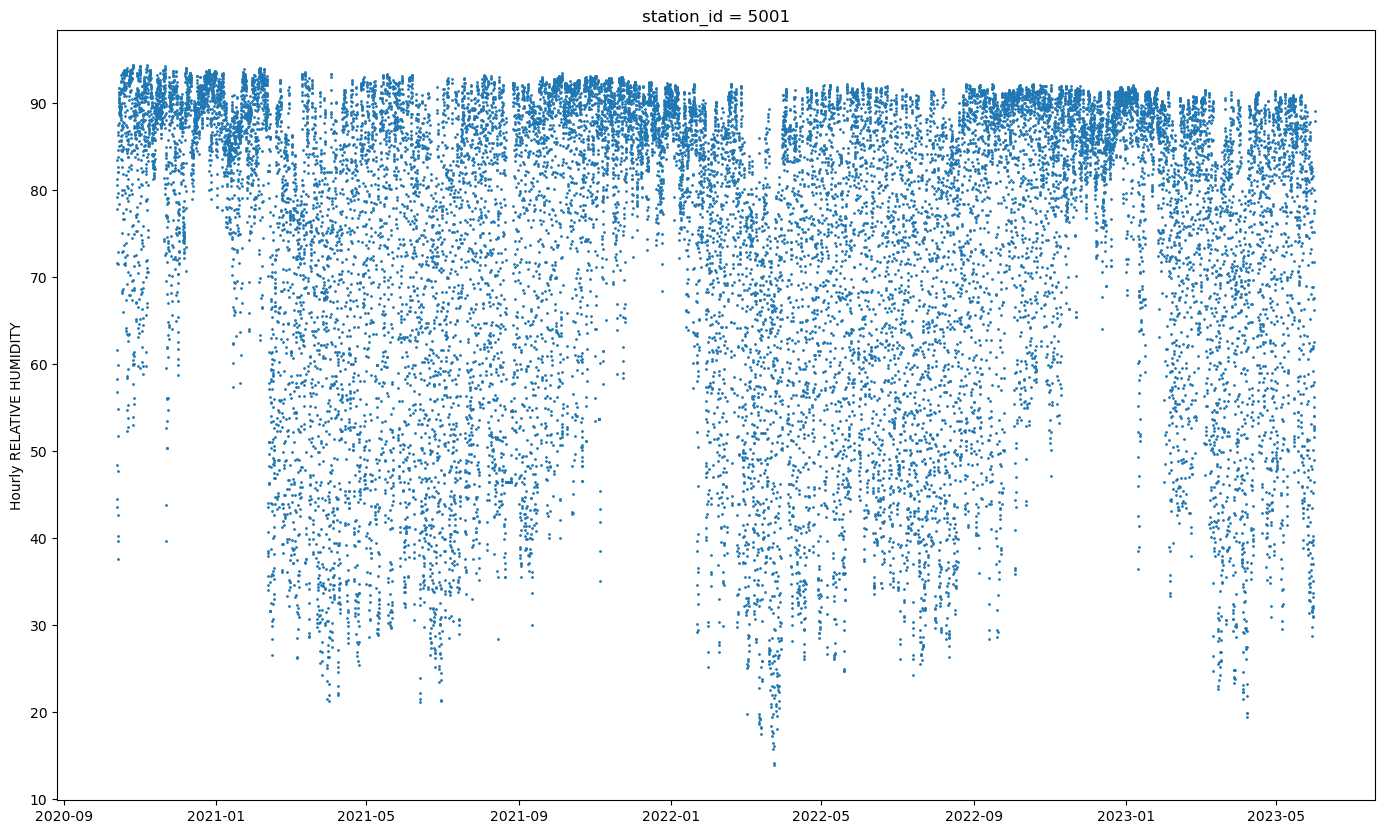

In [7]:
# hourly data
# sum the values for each hour and take the mean

str(humidity_all.index.dtype) # okay
humidity_hourly = humidity_all.resample('H').mean()
print(humidity_hourly)

# plot hourly 'RELATIVE_HUMIDITY'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(humidity_hourly.index, humidity_hourly['RELATIVE_HUMIDITY'],s=1)
ax.set_ylabel('Hourly RELATIVE HUMIDITY')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

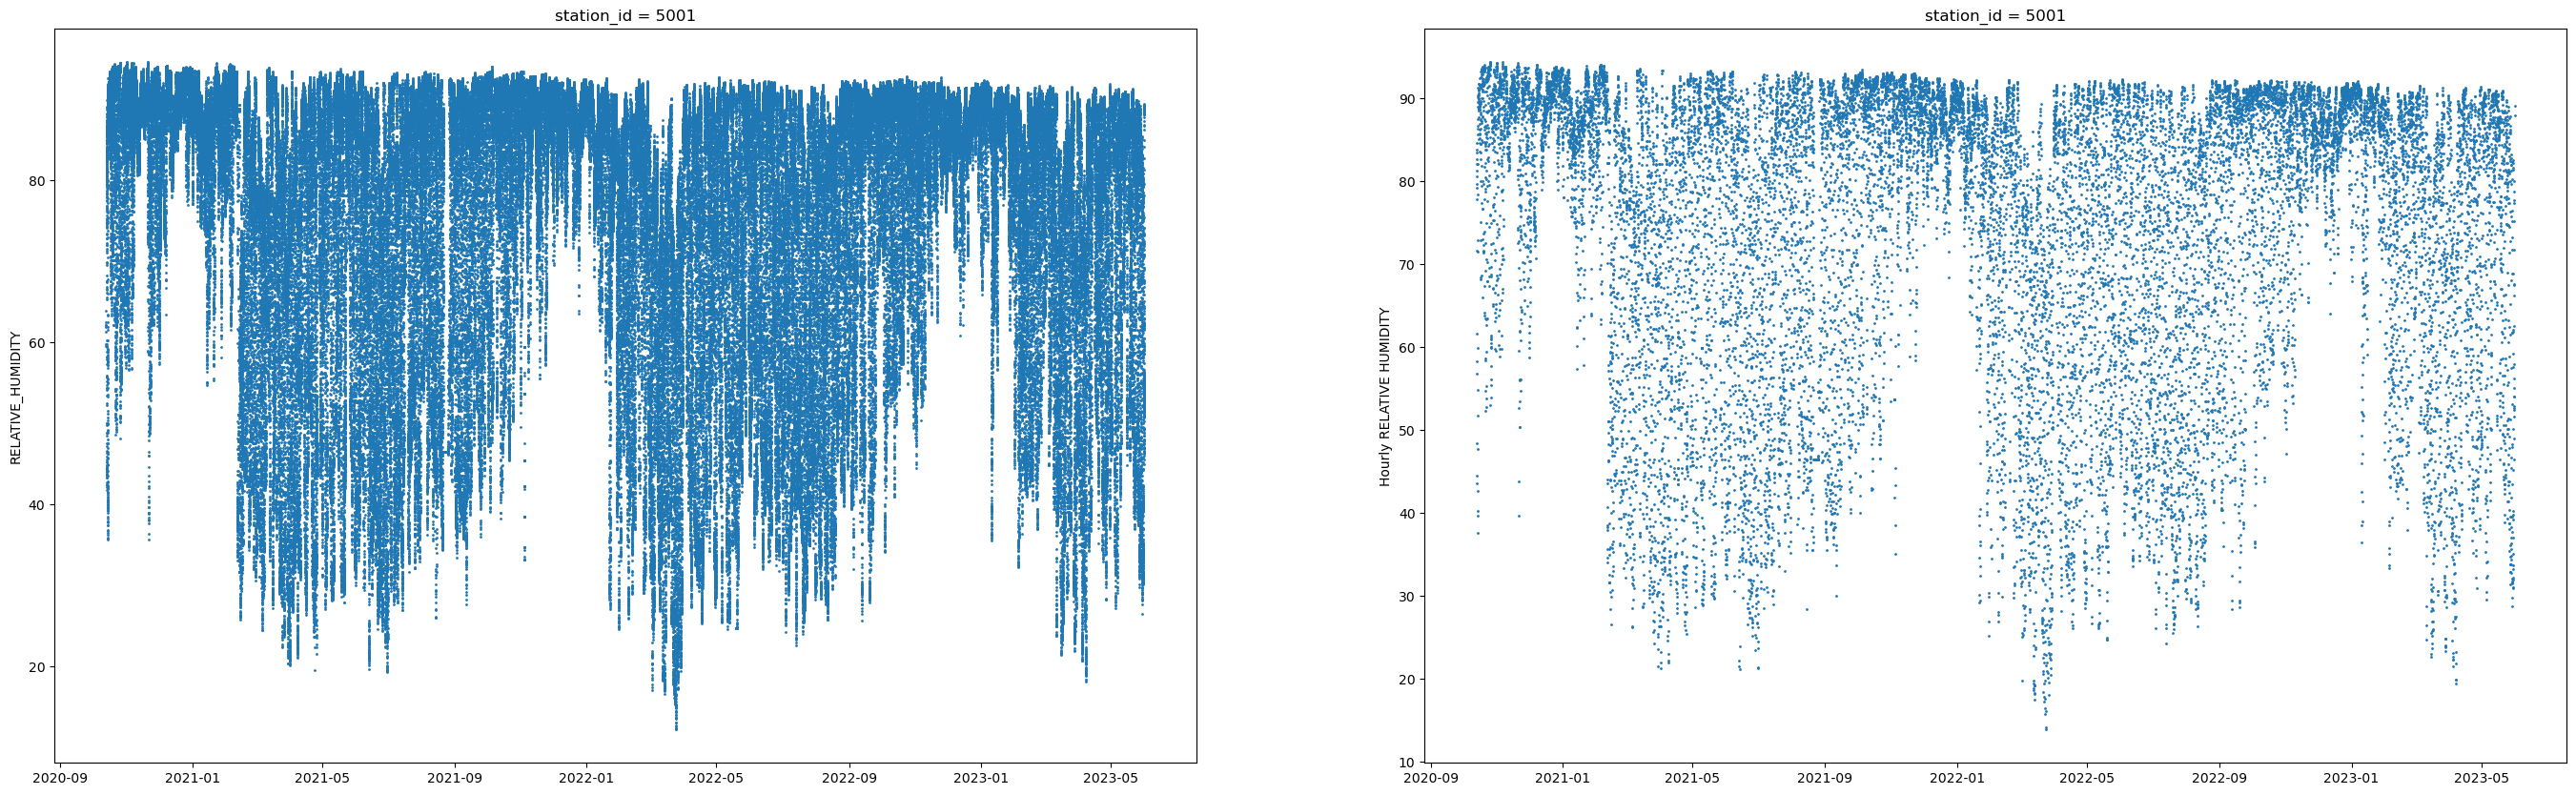

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(34, 10))

axs[0].scatter(humidity_all.index, humidity_all['RELATIVE_HUMIDITY'],s=1)
axs[0].set_ylabel('RELATIVE_HUMIDITY')  
axs[0].set_title(f'station_id = {station_id}')  

axs[1].scatter(humidity_hourly.index, humidity_hourly['RELATIVE_HUMIDITY'],s=1)
axs[1].set_ylabel('Hourly RELATIVE HUMIDITY')  
axs[1].set_title(f'station_id = {station_id}')  

plt.show()

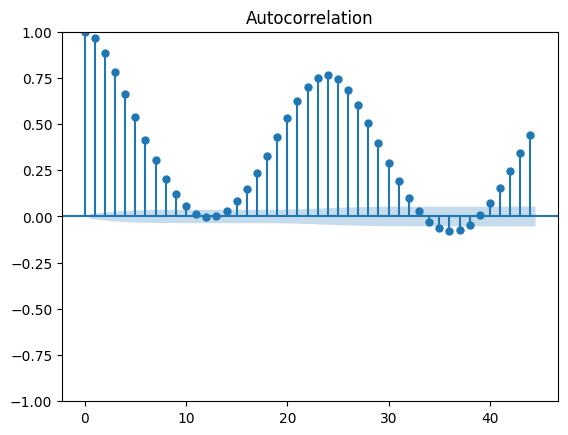

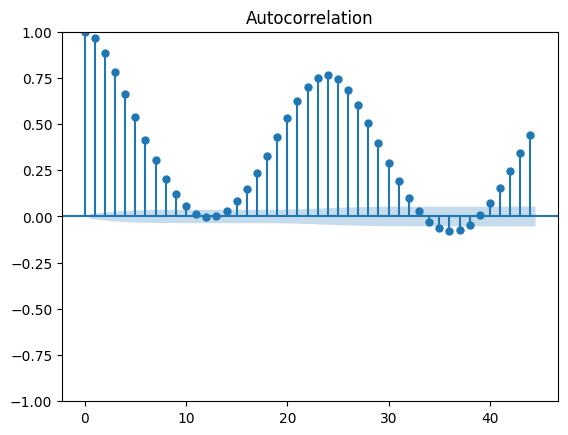

In [ ]:
# ARIMA(p, d, q)

# let's look for a suggestion for d by looking at the autocorellation function (ACF) plot

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(humidity_hourly['RELATIVE_HUMIDITY'])

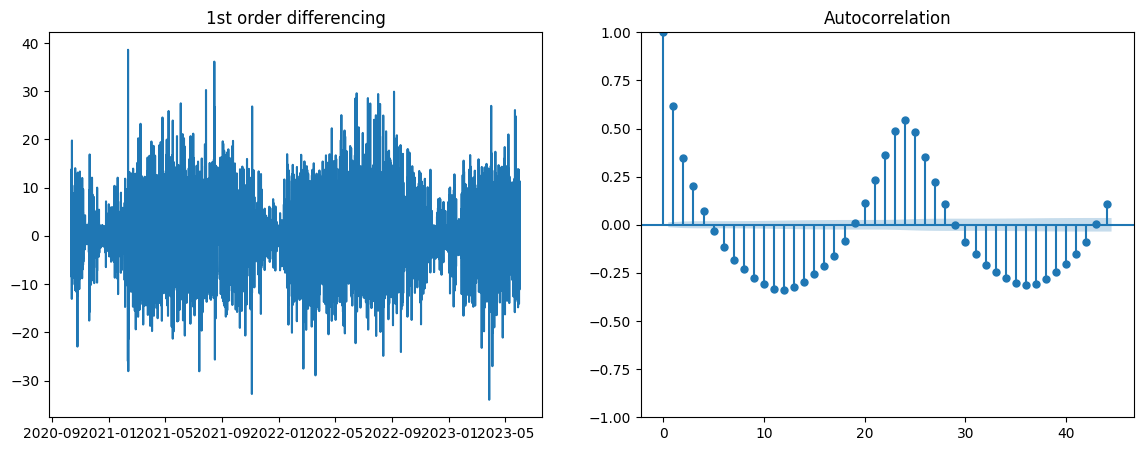

In [ ]:
# first differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(humidity_hourly['RELATIVE_HUMIDITY'].diff())

ax2 = f.add_subplot(122)
plot_acf(humidity_hourly['RELATIVE_HUMIDITY'].diff().dropna(), ax=ax2)
plt.show()


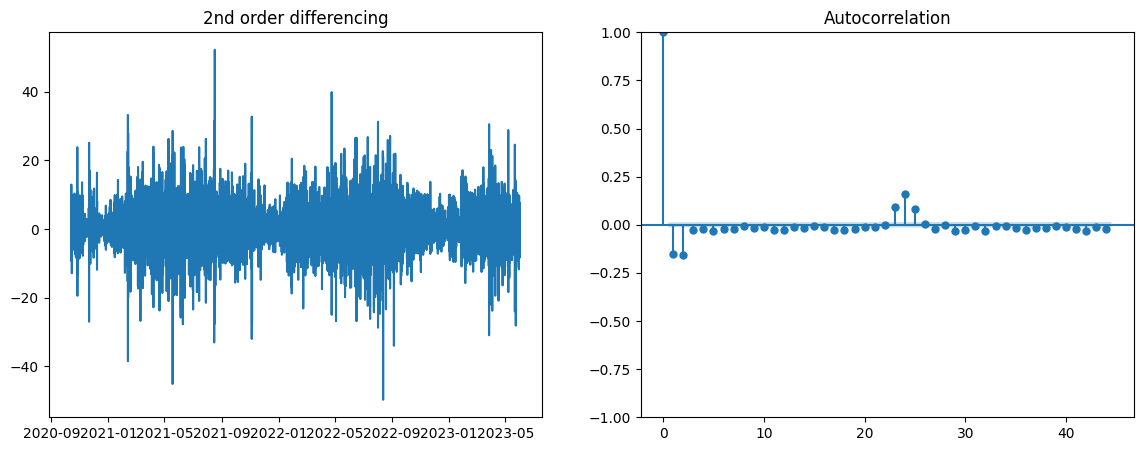

In [ ]:
# second differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(humidity_hourly['RELATIVE_HUMIDITY'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(humidity_hourly['RELATIVE_HUMIDITY'].diff().diff().dropna(), ax=ax2)
plt.show()

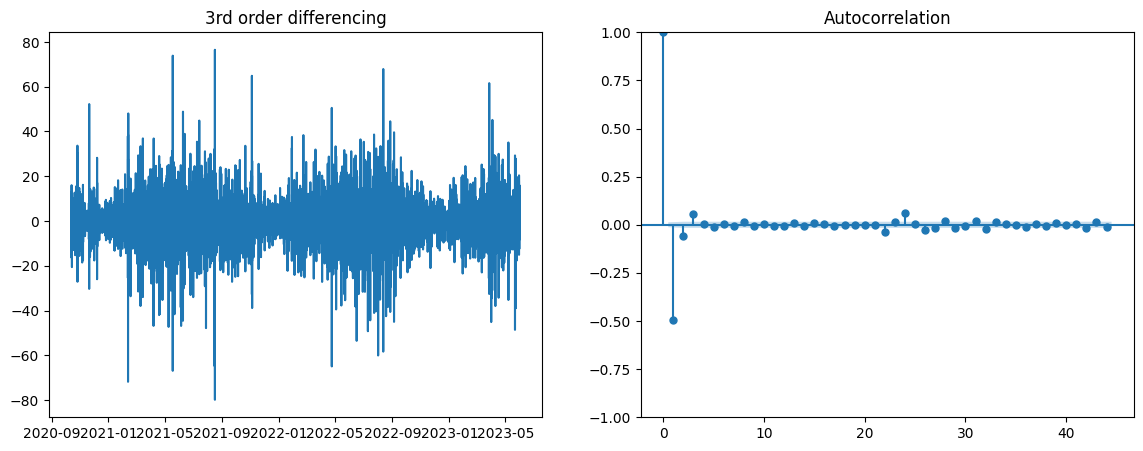

In [ ]:
# third differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('3rd order differencing')
ax1.plot(humidity_hourly['RELATIVE_HUMIDITY'].diff().diff().diff())

ax2 = f.add_subplot(122)
plot_acf(humidity_hourly['RELATIVE_HUMIDITY'].diff().diff().diff().dropna(), ax=ax2)
plt.show()

For deciding the appropriate order of differencind, we can to the Augmented Dickey-Fuller test. (more about it for the report is in the air_pressure files). The ADF test aims to reject the null hypothesis that the given time-series data is non-stationary. It calculates the p-value and compares it with a threshold value or significance level of 0.05. If the p-value is less than this level, then the data is stationary; else, the differencing order is incremented by one.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(humidity_hourly['RELATIVE_HUMIDITY'].dropna())
print('original data p-value:', result[1])

result = adfuller(humidity_hourly['RELATIVE_HUMIDITY'].diff().dropna())
print('1-diff data p-value:', result[1])

result = adfuller(humidity_hourly['RELATIVE_HUMIDITY'].diff().diff().dropna())
print('2-diff data p-value:', result[1])

result = adfuller(humidity_hourly['RELATIVE_HUMIDITY'].diff().diff().diff().dropna())
print('3-diff data p-value:', result[1])

original data p-value: 3.283433234334496e-16
1-diff data p-value: 0.0
2-diff data p-value: 0.0
3-diff data p-value: 0.0


The data is likely stationary.

Now we will look for the best ARIMA(p,d,q) model to fit to the data.

In [ ]:
# 1ST WAY OF FINDING THE BEST FIT

# ARIMA for all the hourly relative humidity data
from pmdarima import auto_arima
stepwise_fit = auto_arima(humidity_hourly, trace=True,
suppress_warnings=True)
# it takes around 10 min

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=126097.554, Time=8.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=137154.375, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=126170.451, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=128531.291, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=137152.377, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=126106.418, Time=2.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=126095.554, Time=4.98 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=126109.442, Time=1.41 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=126112.532, Time=0.84 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=126097.554, Time=8.32 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=126111.254, Time=1.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=20.10 sec


KeyboardInterrupt: 

                               SARIMAX Results                                
Dep. Variable:      RELATIVE_HUMIDITY   No. Observations:                23052
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -63042.777
Date:                Wed, 22 May 2024   AIC                         126093.554
Time:                        01:12:25   BIC                         126125.736
Sample:                    10-13-2020   HQIC                        126104.011
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1578      0.068      2.331      0.020       0.025       0.290
ar.L2          0.2503      0.044      5.661      0.000       0.164       0.337
ma.L1          0.4910      0.067      7.290      0.0

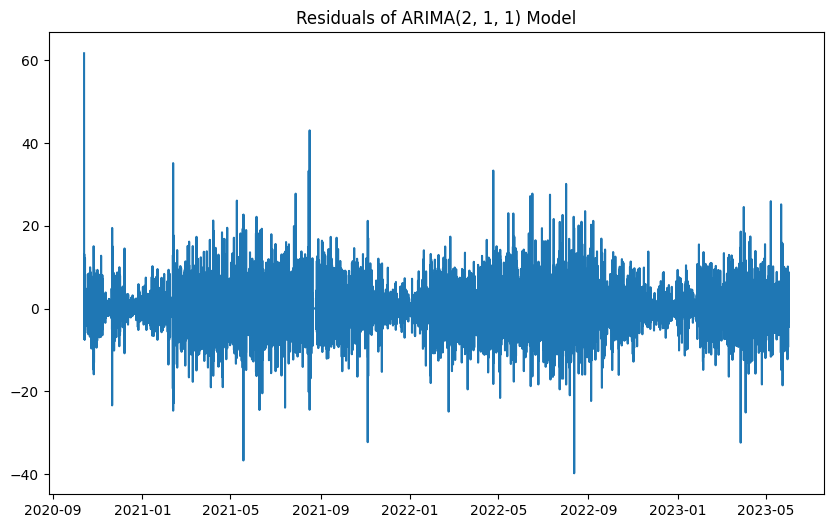

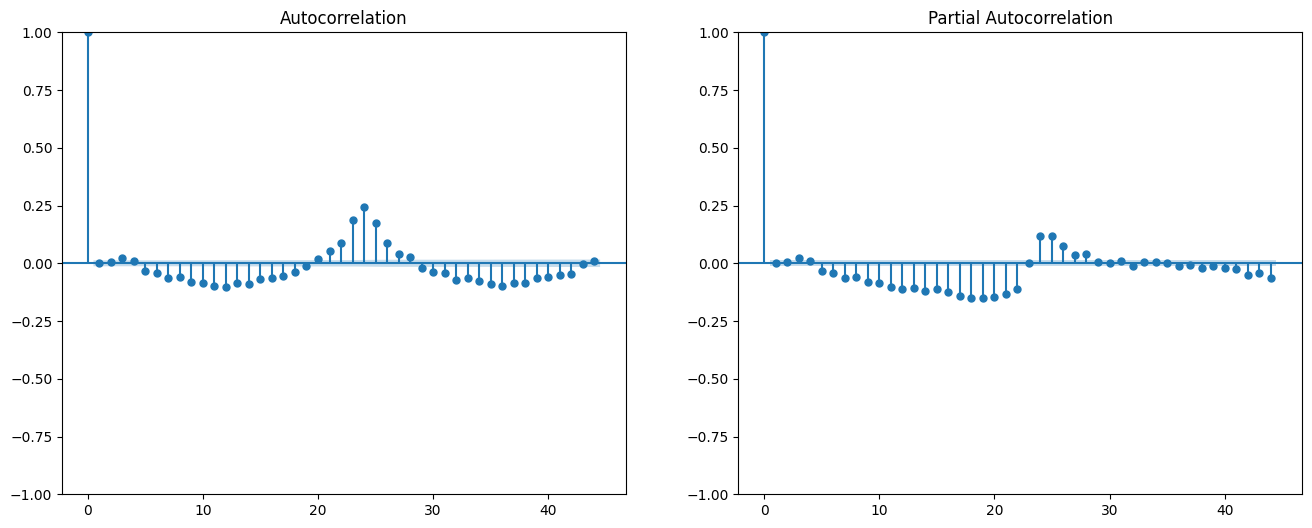

In [ ]:
# fit the model 

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit the best model
best_model = ARIMA(humidity_hourly, order=(2,1,1))   # change order accordingly
best_fit = best_model.fit()

# summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{2,1,1} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0], alpha=0.05)
plot_pacf(residuals_best, ax=ax[1], alpha=0.05)
plt.show()

        Order            AIC            BIC
58  (3, 0, 4)  121353.769162  121426.178733
75  (4, 0, 3)  121497.895084  121570.304654
57  (3, 0, 3)  121731.925982  121796.290045
99  (5, 1, 3)  121979.396094  122051.805274
46  (2, 1, 4)  122022.181221  122078.499472
Best ARIMA order: (3, 0, 4)
                               SARIMAX Results                                
Dep. Variable:      RELATIVE_HUMIDITY   No. Observations:                23052
Model:                 ARIMA(3, 0, 4)   Log Likelihood              -60667.885
Date:                Mon, 20 May 2024   AIC                         121353.769
Time:                        02:09:15   BIC                         121426.179
Sample:                    10-13-2020   HQIC                        121377.297
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

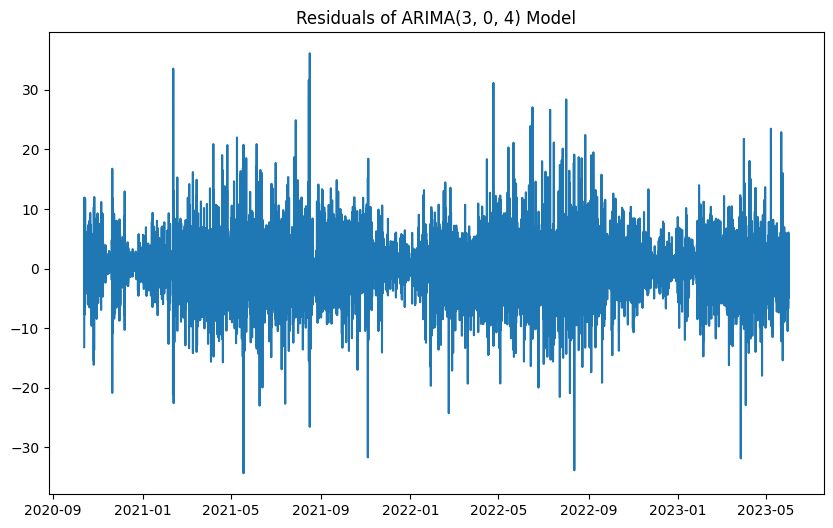

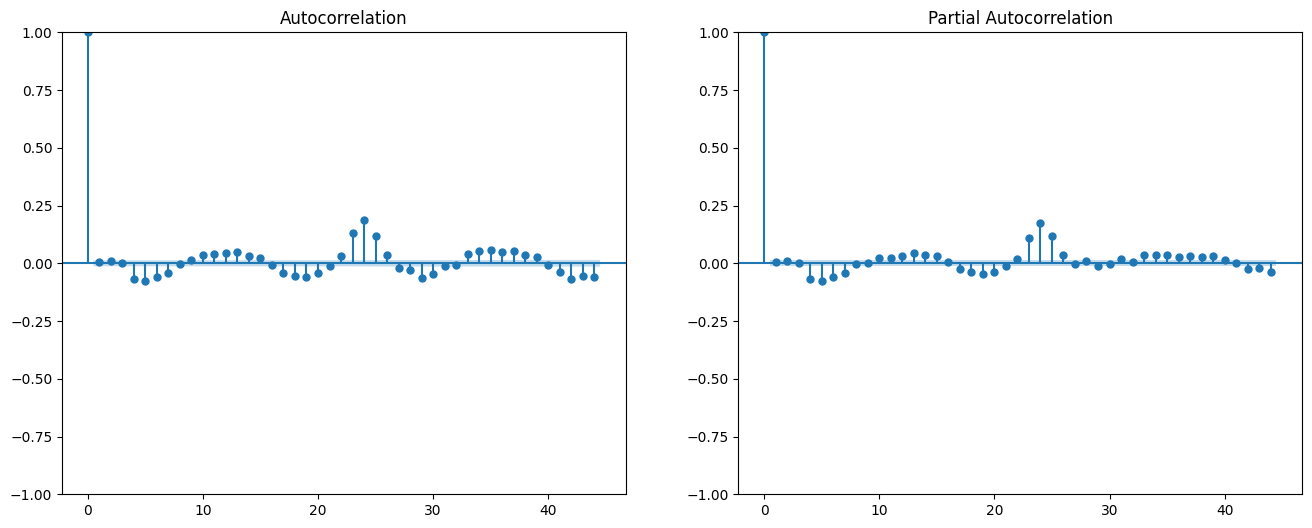

In [ ]:
# 2ND WAY OF FINDING THE BEST FIT

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# define the range for p, d, q parameters
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)

# a list to store the results
results = []

# perform grid search
for i in p:
    for j in d:
        for k in q:
            order = (i, j, k)
            try:
                model = ARIMA(humidity_hourly, order=order)
                fit = model.fit()
                aic = fit.aic
                bic = fit.bic
                results.append((order, aic, bic))
            except:
                continue

# convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Order', 'AIC', 'BIC'])

# sort the results by AIC and BIC
results_df = results_df.sort_values(by='AIC')

# print the top 5 models
print(results_df.head())

# choose the best model based on the lowest AIC
best_order = results_df.iloc[0]['Order']
print(f"Best ARIMA order: {best_order}")

# fit the best model
best_model = ARIMA(humidity_hourly, order=best_order)
best_fit = best_model.fit()

# check the summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{best_order} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0])
plot_pacf(residuals_best, ax=ax[1])
plt.show()

In [ ]:
# data for 2020, 2021, 2022
# fit the best model to this data
# 2 best ARIMAs: (2,1,1) and (3,0,4) - try both
# forecast the next 24 hours 
# compare forecast from ARIMA and simple model with actual values (maybe 2 simple models)
# plot forecasts, plot errors

humidity_20_21_22 = humidity_hourly.loc[(humidity_hourly.index.year == 2020) | (humidity_hourly.index.year == 2021) | (humidity_hourly.index.year == 2022) , 'RELATIVE_HUMIDITY']
print(humidity_20_21_22)

2020-10-13 10:00:00+00:00    61.675000
2020-10-13 11:00:00+00:00    56.825000
2020-10-13 12:00:00+00:00    48.391667
2020-10-13 13:00:00+00:00    43.625000
2020-10-13 14:00:00+00:00    44.483333
                               ...    
2022-12-31 19:00:00+00:00    89.791667
2022-12-31 20:00:00+00:00    89.700000
2022-12-31 21:00:00+00:00    90.508333
2022-12-31 22:00:00+00:00    90.883333
2022-12-31 23:00:00+00:00    90.933333
Freq: H, Name: RELATIVE_HUMIDITY, Length: 19430, dtype: float64


Now we will create a simple models to later compare it with the ARIMA models we fitted to the data.

Simple model: Average of the previous 3 days is the value for the next day.

We fitted ARIMA models to all the hourly data. We will fit the models to the data for just 2020, 2021 and 2022 and then forecast 1 day (24 steps into the 'future', which is the start of the year 2023).

We will then compare the models with the actual data and see which model gives the best forecast. Hopefully it is the ARIMA model.

In [ ]:
# 1st simple model
# average of the previous 3 days is the value for the next day

def last_3_days_average(data, forecasted_steps):
    # Forecasts the next values based on the average of the last 3 days at the same time.
    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1) # finds out the next time step
        
        last_3_days = [
            next_time_step - pd.Timedelta(days=i) for i in range(1, 4)     # gets the same hour from the last 3 days
        ]
        
        values = [data[data.index == dt].values for dt in last_3_days] # extracts the values at the same hour from the last 3 days
        values = [val[0] if len(val) > 0 else np.nan for val in values]
        
        forecast_value = np.nanmean(values) # mean of the last 3 days
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])]) # adds the forecasted value to the data for the next iteration

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

last_3_days_average(humidity_20_21_22, 24)

last_3_humidity = last_3_days_average(humidity_20_21_22, 24)


In [ ]:
# 2nd simple model
# today's measurement is tomorrow's forecast

def today_is_tomorrow(data, forecasted_steps):

    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1)
        
        same_hour_last_day = next_time_step - pd.Timedelta(days=1)
        
        forecast_value = data.loc[same_hour_last_day]
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])])

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

today_is_tomorrow(humidity_20_21_22, 24)

today_is_tomorrow_humidity = today_is_tomorrow(humidity_20_21_22, 24)


In [ ]:
# ARIMA(2,1,1) (1st fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# fit
model_211 = ARIMA(humidity_20_21_22, order=(2,1,1))
fit_211 = model_211.fit()

# summary of the fit
print(fit_211.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_211 = fit_211.get_forecast(steps=24)
forecast_values_211 = forecast_result_211.predicted_mean
conf_int_211 = forecast_result_211.conf_int()

print("Forecasted values:", forecast_values_211)
print("95% Confidence intervals of forecasts:", conf_int_211)


                               SARIMAX Results                                
Dep. Variable:      RELATIVE_HUMIDITY   No. Observations:                19430
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -53275.768
Date:                Wed, 22 May 2024   AIC                         106559.536
Time:                        01:12:32   BIC                         106591.034
Sample:                    10-13-2020   HQIC                        106569.856
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1547      0.071      2.194      0.028       0.016       0.293
ar.L2          0.2482      0.046      5.396      0.000       0.158       0.338
ma.L1          0.4917      0.070      7.005      0.0

In [ ]:
print(forecast_values_211)

2023-01-01 00:00:00+00:00    90.964148
2023-01-01 01:00:00+00:00    90.981324
2023-01-01 02:00:00+00:00    90.991628
2023-01-01 03:00:00+00:00    90.997485
2023-01-01 04:00:00+00:00    91.000948
2023-01-01 05:00:00+00:00    91.002938
2023-01-01 06:00:00+00:00    91.004105
2023-01-01 07:00:00+00:00    91.004779
2023-01-01 08:00:00+00:00    91.005173
2023-01-01 09:00:00+00:00    91.005401
2023-01-01 10:00:00+00:00    91.005534
2023-01-01 11:00:00+00:00    91.005612
2023-01-01 12:00:00+00:00    91.005657
2023-01-01 13:00:00+00:00    91.005683
2023-01-01 14:00:00+00:00    91.005698
2023-01-01 15:00:00+00:00    91.005707
2023-01-01 16:00:00+00:00    91.005712
2023-01-01 17:00:00+00:00    91.005715
2023-01-01 18:00:00+00:00    91.005717
2023-01-01 19:00:00+00:00    91.005718
2023-01-01 20:00:00+00:00    91.005718
2023-01-01 21:00:00+00:00    91.005719
2023-01-01 22:00:00+00:00    91.005719
2023-01-01 23:00:00+00:00    91.005719
Freq: H, Name: predicted_mean, dtype: float64


In [ ]:
# ARIMA(3,0,4) (2nd fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# fit
model_304 = ARIMA(humidity_20_21_22, order=(3,0,4))
fit_304 = model_304.fit()

# summary of the fit
print(fit_304.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_304 = fit_304.get_forecast(steps=24)
forecast_values_304 = forecast_result_304.predicted_mean
conf_int_304 = forecast_result_304.conf_int()

print("Forecasted values:", forecast_values_304)
print("95% Confidence intervals of forecasts:", conf_int_304)





                               SARIMAX Results                                
Dep. Variable:      RELATIVE_HUMIDITY   No. Observations:                19430
Model:                 ARIMA(3, 0, 4)   Log Likelihood              -51288.686
Date:                Wed, 22 May 2024   AIC                         102595.372
Time:                        01:12:56   BIC                         102666.243
Sample:                    10-13-2020   HQIC                        102618.591
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.0935      0.701    107.108      0.000      73.719      76.468
ar.L1          2.8673      0.003    841.850      0.000       2.861       2.874
ar.L2         -2.8070      0.007   -428.736      0.0

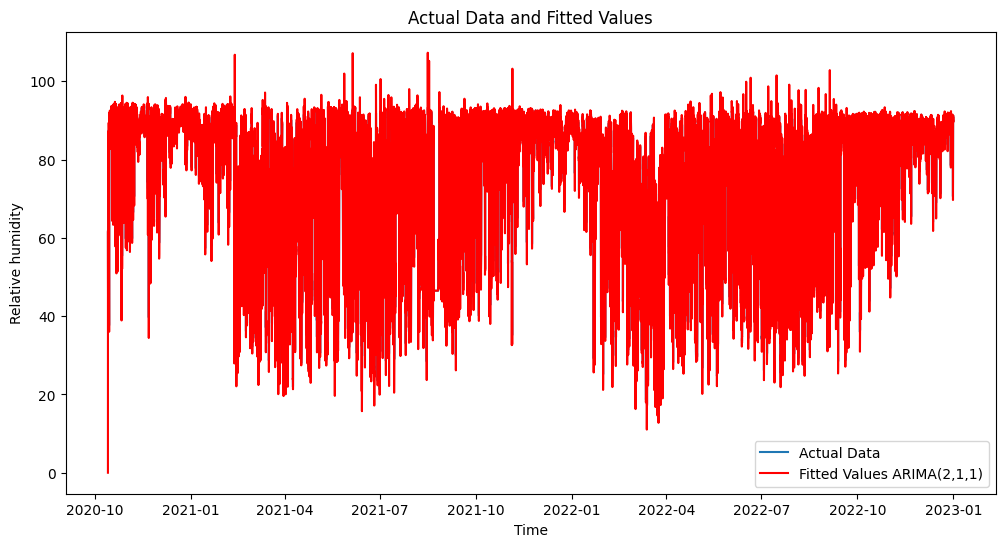

In [ ]:
# plot actual data and fitted values - 1ST ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_211 = fit_211.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(humidity_20_21_22.index, humidity_20_21_22, label='Actual Data')
plt.plot(humidity_20_21_22.index, fitted_values_211, color='red', label='Fitted Values ARIMA(2,1,1)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Relative humidity')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

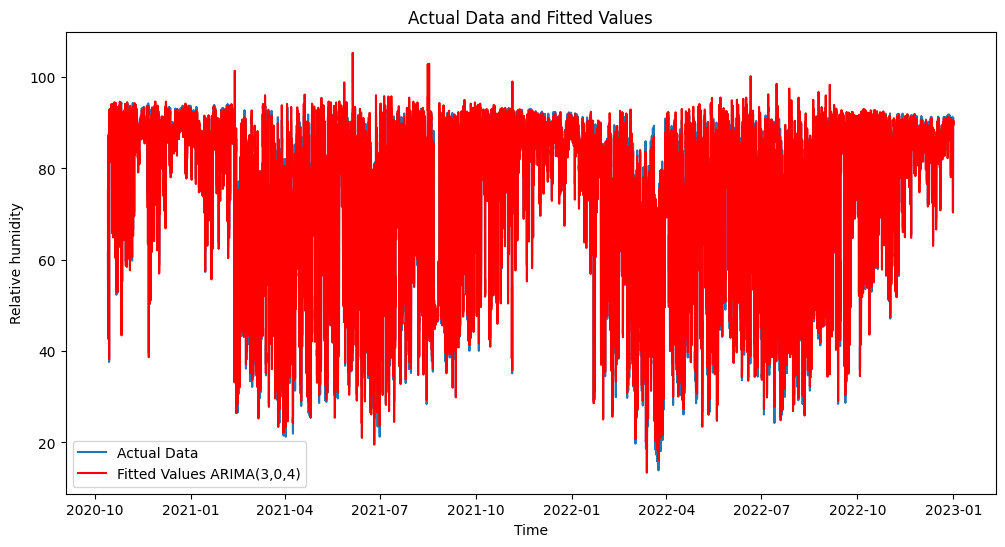

In [ ]:
# plot actual data and fitted values - 2ND ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_304 = fit_304.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(humidity_20_21_22.index, humidity_20_21_22, label='Actual Data')
plt.plot(humidity_20_21_22.index, fitted_values_304, color='red', label='Fitted Values ARIMA(3,0,4)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Relative humidity')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

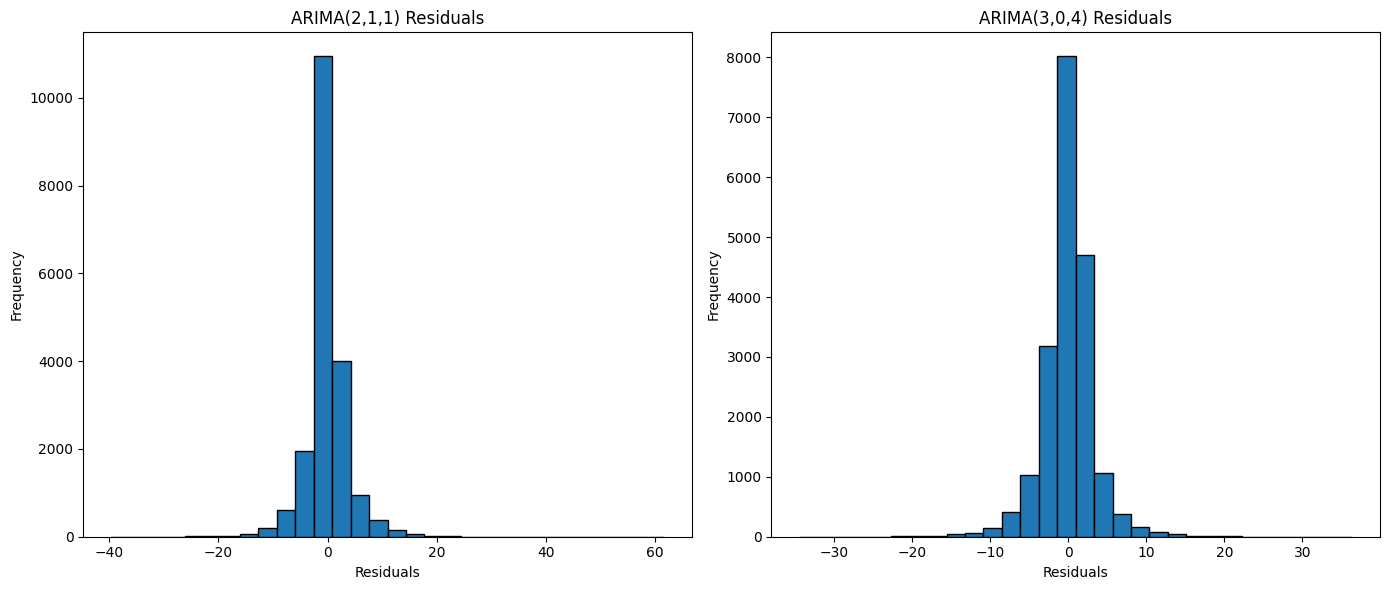

In [ ]:
# comparison of the histograms

# residuals
residuals_211 = fit_211.resid
residuals_304 = fit_304.resid

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(residuals_211, bins=30, edgecolor='k')
plt.title('ARIMA(2,1,1) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(residuals_304, bins=30, edgecolor='k')
plt.title('ARIMA(3,0,4) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')



plt.tight_layout()
plt.show()


The residuals in a time series model are what is left over after fitting a model. The residuals are equal to the difference between the observations and the corresponding fitted values.

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will have residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In [ ]:
# statistical test and metricts to determine which model is better

import math 
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# mean of the residuals (should be 0)
mean1 = np.mean(residuals_211)
mean2 = np.mean(residuals_304)
#print(mean1, mean2)

# AIC (already done above) - writte about AIC in the report
aic1 = fit_211.aic
aic2 = fit_304.aic
#print(aic1, aic2)
# lower is better
if aic1 < aic2:
    print('ARIMA(2,1,1) is better based on AIC.')
else:
    print('ARIMA(3,0,4) is preferred based on AIC.')

# Ljung-Box test for autocorrelation - see model fit output

# BIC - see model fit output

ARIMA(3,0,4) is preferred based on AIC.


Mean Absolute Error: 2.2252070601555727
Mean Squared Error: 11.497513687592425


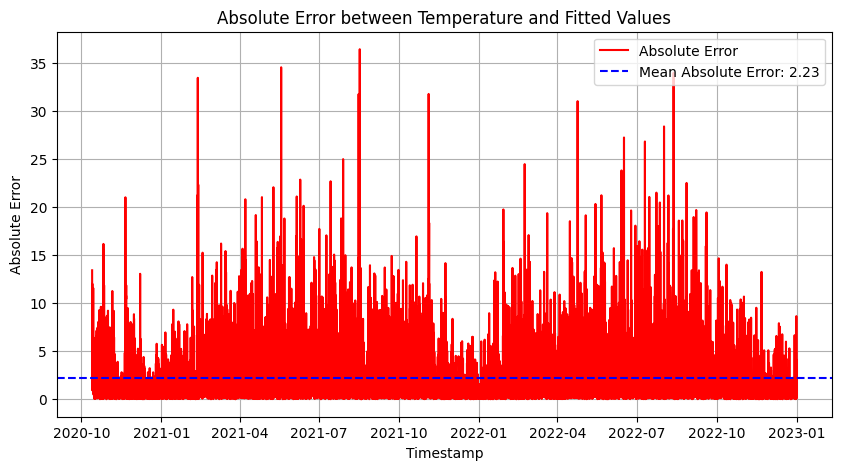

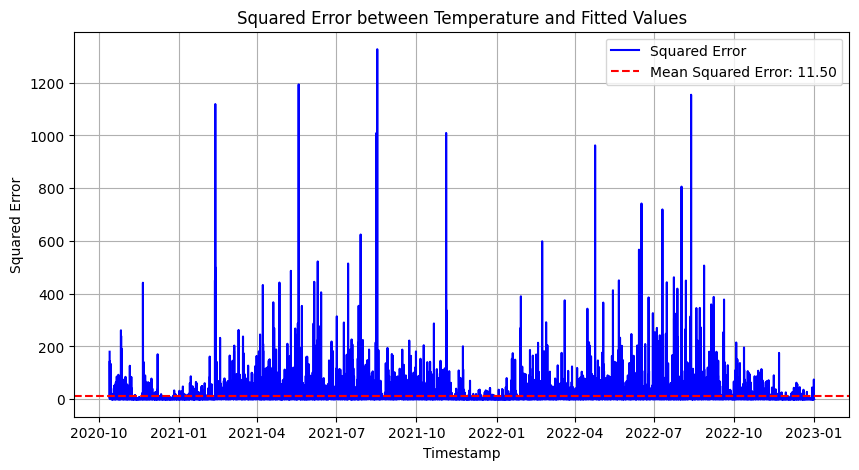

In [ ]:
# absolute error comparison - actual data vs fitted model data

def calculate_errors(data, model): 
      # model are fitted values of a chosen model
  if isinstance(data, pd.Series) and isinstance(model, pd.Series):
        absolute_error = (data - model).abs()
        squared_error = (data - model) ** 2
  elif isinstance(data, np.ndarray) and isinstance(model, np.ndarray):
        absolute_error = np.abs(data - model)
        squared_error = (data - model) ** 2
  errors = pd.DataFrame({
        'absolute_error': absolute_error,
        'squared_error': squared_error
  })

  return errors

# (3,0,4) is the preferred, lets compare this data with actual data
# actual data - temperature_20_21_22
# fitted values data - fitted_values_412 

errors = calculate_errors(humidity_20_21_22, fitted_values_304 )

# mean errors
mean_absolute_error = errors['absolute_error'].mean()
mean_squared_error = errors['squared_error'].mean()
print("Mean Absolute Error:", mean_absolute_error)
print("Mean Squared Error:", mean_squared_error)

# plot of the absolute error
plt.figure(figsize=(10, 5))
plt.plot(errors['absolute_error'], label='Absolute Error', color='red')
plt.axhline(y=mean_absolute_error, color='blue', linestyle='--', label=f'Mean Absolute Error: {mean_absolute_error:.2f}')
plt.xlabel('Timestamp')
plt.ylabel('Absolute Error')
plt.title('Absolute Error between Temperature and Fitted Values')
plt.legend()
plt.grid(True)
plt.show()

# plot of the squared error
plt.figure(figsize=(10, 5))
plt.plot(errors['squared_error'], label='Squared Error', color='blue')
plt.axhline(y=mean_squared_error, color='red', linestyle='--', label=f'Mean Squared Error: {mean_squared_error:.2f}')
plt.xlabel('Timestamp')
plt.ylabel('Squared Error')
plt.title('Squared Error between Temperature and Fitted Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
    

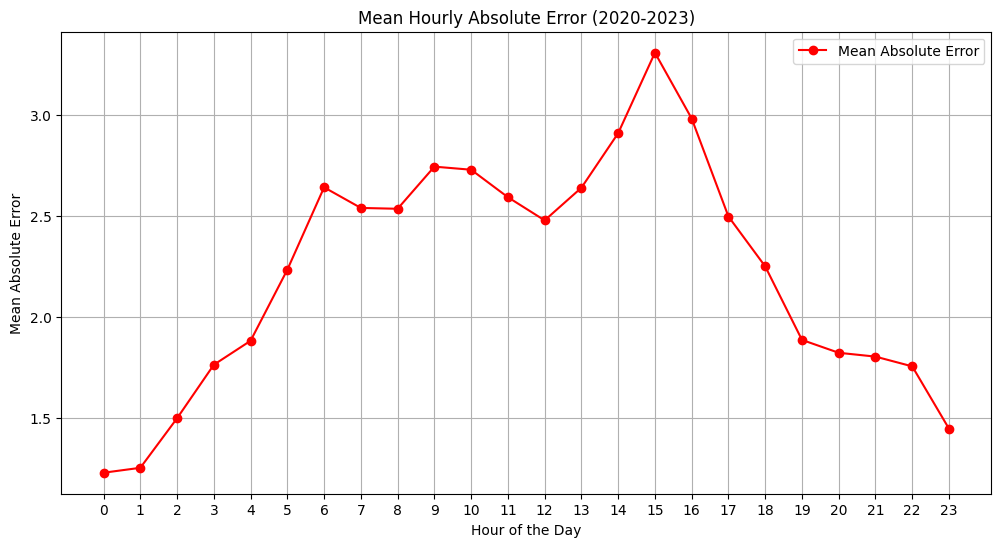

Hour
0     1.227957
1     1.252298
2     1.497565
3     1.762461
4     1.881197
5     2.233138
6     2.640818
7     2.538875
8     2.534722
9     2.743321
10    2.728044
11    2.592009
12    2.477377
13    2.638957
14    2.909070
15    3.307327
16    2.981361
17    2.496373
18    2.249388
19    1.885447
20    1.821729
21    1.802808
22    1.754524
23    1.445810
Name: absolute_error, dtype: float64


In [ ]:
# mean hourly absolute errors

errors['Hour'] = errors.index.hour

# mean
mean_absolute_errors_by_hour = errors.groupby('Hour')['absolute_error'].mean()

# plot
plt.figure(figsize=(12, 6))
plt.plot(mean_absolute_errors_by_hour.index, mean_absolute_errors_by_hour, label='Mean Absolute Error', marker='o', color='red')

plt.xlabel('Hour of the Day')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Hourly Absolute Error (2020-2023)')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(range(24))
plt.show()

print(mean_absolute_errors_by_hour)

In [ ]:
# actual measurements for 1 day (24 steps) into the future
r_humidity_hourly = humidity_hourly['RELATIVE_HUMIDITY']
actual_values_humidity_23 = r_humidity_hourly['2023'].head(24)
print(actual_values_humidity_23)

2023-01-01 00:00:00+00:00    91.266667
2023-01-01 01:00:00+00:00    91.166667
2023-01-01 02:00:00+00:00    91.116667
2023-01-01 03:00:00+00:00    90.108333
2023-01-01 04:00:00+00:00    90.500000
2023-01-01 05:00:00+00:00    90.441667
2023-01-01 06:00:00+00:00    90.266667
2023-01-01 07:00:00+00:00    90.133333
2023-01-01 08:00:00+00:00    89.858333
2023-01-01 09:00:00+00:00    83.083333
2023-01-01 10:00:00+00:00    75.358333
2023-01-01 11:00:00+00:00    71.483333
2023-01-01 12:00:00+00:00    68.558333
2023-01-01 13:00:00+00:00    67.941667
2023-01-01 14:00:00+00:00    74.966667
2023-01-01 15:00:00+00:00    84.858333
2023-01-01 16:00:00+00:00    88.208333
2023-01-01 17:00:00+00:00    89.591667
2023-01-01 18:00:00+00:00    90.508333
2023-01-01 19:00:00+00:00    90.766667
2023-01-01 20:00:00+00:00    91.108333
2023-01-01 21:00:00+00:00    91.000000
2023-01-01 22:00:00+00:00    90.625000
2023-01-01 23:00:00+00:00    91.233333
Freq: H, Name: RELATIVE_HUMIDITY, dtype: float64


                              Actual  ARIMA(2,1,1)  ARIMA(3,0,4)  \
2023-01-01 00:00:00+00:00  91.266667     90.964148     90.168701   
2023-01-01 01:00:00+00:00  91.166667     90.981324     88.935144   
2023-01-01 02:00:00+00:00  91.116667     90.991628     87.473632   
2023-01-01 03:00:00+00:00  90.108333     90.997485     85.901665   
2023-01-01 04:00:00+00:00  90.500000     91.000948     84.282054   
2023-01-01 05:00:00+00:00  90.441667     91.002938     82.683389   
2023-01-01 06:00:00+00:00  90.266667     91.004105     81.175177   
2023-01-01 07:00:00+00:00  90.133333     91.004779     79.822944   
2023-01-01 08:00:00+00:00  89.858333     91.005173     78.683641   
2023-01-01 09:00:00+00:00  83.083333     91.005401     77.801646   
2023-01-01 10:00:00+00:00  75.358333     91.005534     77.205658   
2023-01-01 11:00:00+00:00  71.483333     91.005612     76.906668   
2023-01-01 12:00:00+00:00  68.558333     91.005657     76.897152   
2023-01-01 13:00:00+00:00  67.941667     91.0056

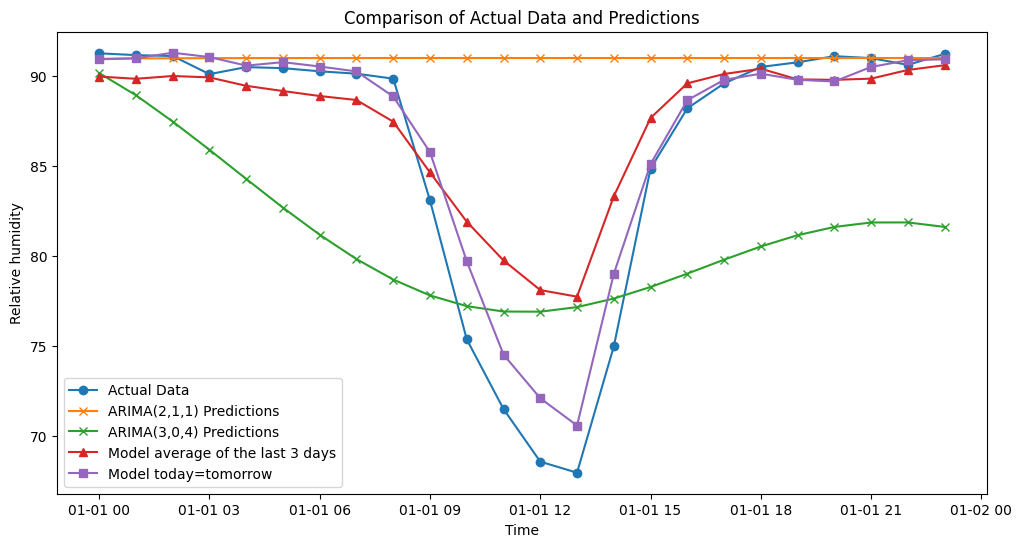

In [ ]:
# comparing the models with the actual data
# change p,d,q to the best found

comparison_humidity = pd.DataFrame({
    'Actual': actual_values_humidity_23,
    'ARIMA(2,1,1)': forecast_values_211,
    'ARIMA(3,0,4)': forecast_values_304,
    'Model average of the last 3 days': last_3_humidity,
    'Model today=tomorrow': today_is_tomorrow_humidity
})

print(comparison_humidity)

plt.figure(figsize=(12,6))

plt.plot(comparison_humidity.index, comparison_humidity['Actual'], label='Actual Data', marker='o')
plt.plot(comparison_humidity.index, comparison_humidity['ARIMA(2,1,1)'], label='ARIMA(2,1,1) Predictions', marker='x')
plt.plot(comparison_humidity.index, comparison_humidity['ARIMA(3,0,4)'], label='ARIMA(3,0,4) Predictions', marker='x')
plt.plot(comparison_humidity.index, comparison_humidity['Model average of the last 3 days'], label='Model average of the last 3 days', marker='^')
plt.plot(comparison_humidity.index, comparison_humidity['Model today=tomorrow'], label='Model today=tomorrow', marker='s')

plt.xlabel('Time')
plt.ylabel('Relative humidity')
plt.title('Comparison of Actual Data and Predictions')
plt.legend()
plt.show()

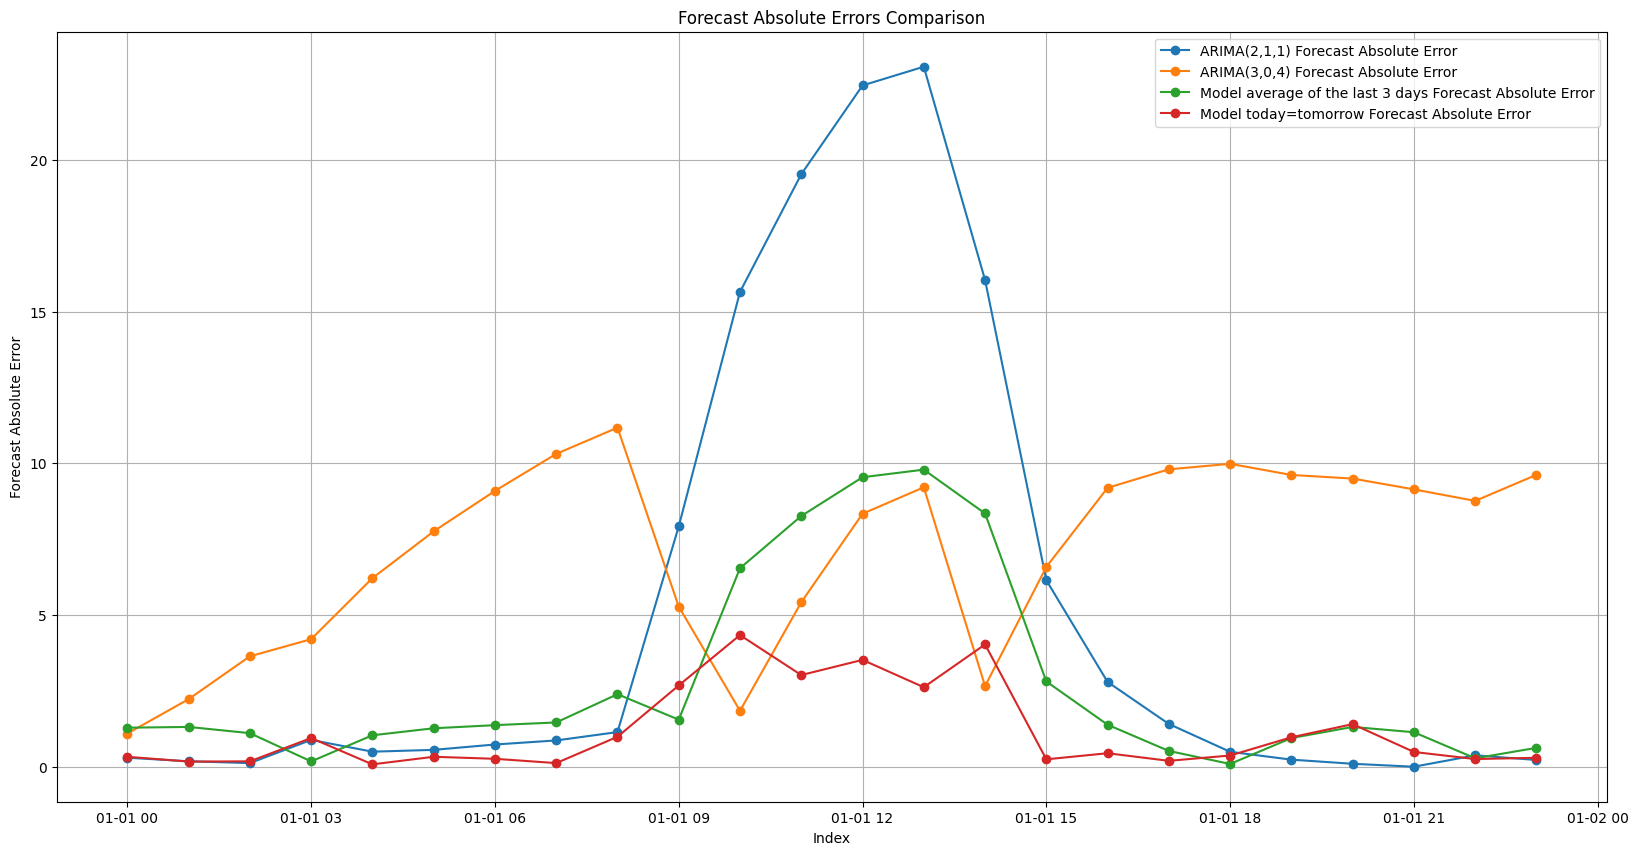

ARIMA(2,1,1) Forecast Absolute Error                        5.073909
ARIMA(3,0,4) Forecast Absolute Error                        7.112547
Model average of the last 3 days Forecast Absolute Error    2.693171
Model today=tomorrow Forecast Absolute Error                1.182639
dtype: float64


In [ ]:
# 4 models' predictions compared to the actual data

# absolute errors of all the modela
forecast_absolute_errors = pd.DataFrame()
for column in comparison_humidity.columns:
    if column != 'Actual':
        forecast_absolute_errors[column + ' Forecast Absolute Error'] = (comparison_humidity['Actual'] - comparison_humidity[column]).abs()

# plot
plt.figure(figsize=(20, 10))
for column in forecast_absolute_errors.columns:
    plt.plot(forecast_absolute_errors[column], label=column, marker='o')

plt.xlabel('Index')
plt.ylabel('Forecast Absolute Error')
plt.title('Forecast Absolute Errors Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# values 
#print(forecast_absolute_errors)

# mean errors
print(forecast_absolute_errors.mean())
